In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
players_info <- read_csv('data/players.csv')
tidy_players_info <- players_info |>
    mutate(subscribe = as.factor(subscribe)) |>
    mutate(experience = as.factor(experience)) |>
    select(subscribe, played_hours, Age)

head(tidy_players_info) 

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


Warning message:
“tune samples were requested but there were 147 rows in the data. 142 will be used.”
→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 29 rows.
               ✖ Assigned data has 30 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 30 to size 29.

There were issues with some computations   A: x1

There were issues with some computations   A: x2





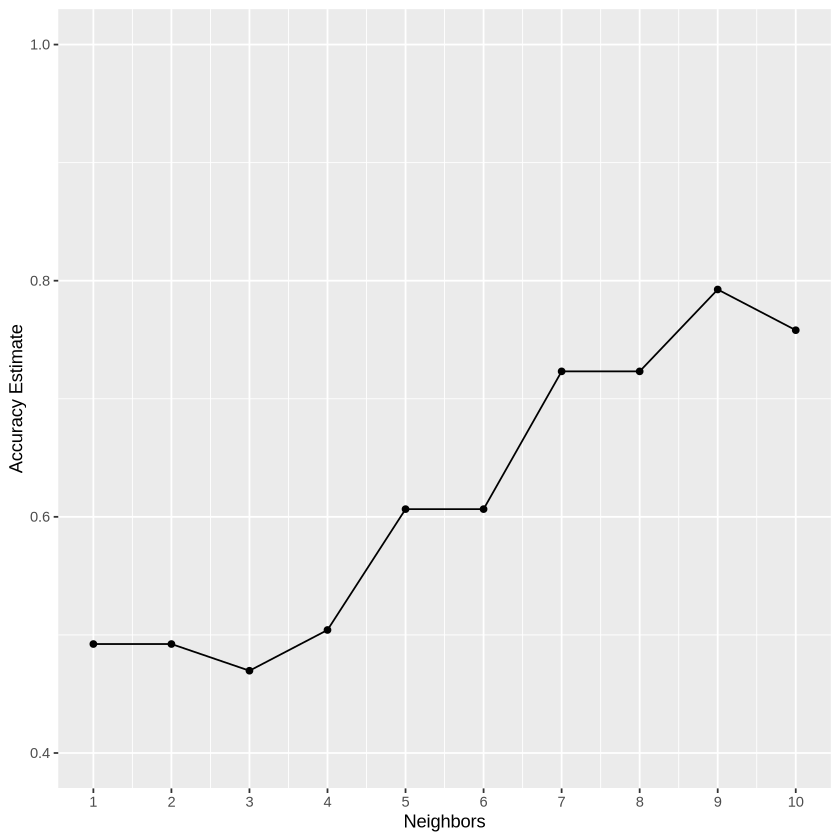

In [25]:
library(tidymodels)


player_split <- initial_split(tidy_players_info, prop = 0.75, strata = subscribe)  
player_train <- training(player_split)   
player_test <- testing(player_split)

player_recipe <- recipe(subscribe ~ played_hours + Age, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

player_fit <- workflow() |>
      add_recipe(player_recipe) |>
      add_model(player_spec) |>
      fit(data = player_train)

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

player_knn_results <- workflow() |>
      add_recipe(player_recipe) |>
      add_model(player_spec) |>
      tune_grid(resamples = player_vfold, grid = k_vals) |>
      collect_metrics()

accuracies <- player_knn_results |> 
      filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) + # 
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
cross_val_plot

In [27]:
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

player_fit <- workflow() |>
      add_recipe(player_recipe) |>
      add_model(player_spec) |>
      fit(data = player_train)
player_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(9,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2482759
Best kernel: rectangular
Best k: 9